In [15]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import bitfinex
from datetime import datetime
import time


from sklearn.model_selection import train_test_split


import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from keras.callbacks import LearningRateScheduler
from keras.metrics import RootMeanSquaredError

In [57]:
df = pd.read_csv("Elrond.csv")
df.fillna(method= 'ffill')
df['Date'] = pd.to_datetime(df['Date'])
df.drop(columns='Currency', axis=1, inplace=True)

In [192]:
X_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(0,1))

In [194]:
def Dataset(Data, Date, X_scaler, y_scaler):

  index = Data.index[Data['Date'] == Date][0]
  X = Data.drop(columns=['Date', 'Close'], axis=1).to_numpy()
  y = Data['Close'].to_numpy()

  X = X_scaler.fit_transform(np.array(X))
  y = y_scaler.fit_transform(np.array(y).reshape(-1,1))
  
  X_train = X[:index]
  y_train = y[:index]
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

  X_test = X[index:]
  y_test = y[index:]
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

  return X_train, y_train, X_test, y_test

# LSTM Model

In [180]:
def Model():
  model = Sequential([
                    # LSTM(200, input_shape = (4, 1), activation = 'relu', return_sequences = True),
                    # LSTM(200, activation = 'relu'),
                    # Dense(200, activation = 'relu'),
                    # Dense(100, activation = 'relu'),
                    # Dense(50, activation = 'relu'),
                    # Dense(4, activation = 'relu'),
                    # Dense(1, activation = 'relu')
                    LSTM(4, input_shape=(X_train.shape[1], 1)),
                    Dense(1),
                    Dropout(0.2)
                    ])
  return model

In [181]:
model = Model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 4)                 96        
                                                                 
 dense_43 (Dense)            (None, 1)                 5         
                                                                 
 dropout (Dropout)           (None, 1)                 0         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [130]:
def scheduler(epoch):
  
  if epoch <= 150:
    lrate = (10 ** -4) * (epoch / 150) 
  elif epoch <= 400:
    initial_lrate = (10 ** -4)
    k = 0.01
    lrate = initial_lrate * math.exp(-k * (epoch - 150))
  else:
    lrate = (10 ** -5)
  
  return lrate

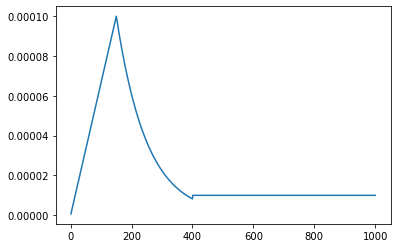

In [131]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [132]:
callback = LearningRateScheduler(scheduler)

# EGLD

In [195]:
date = '2022-02-01'
X_train, y_train, X_test, y_test = Dataset(df, date, X_scaler, y_scaler)

In [172]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((515, 4, 1), (515, 1), (63, 4, 1), (63, 1))

In [182]:
egld_model = Model()

In [183]:
egld_model.compile(loss='mean_squared_error', optimizer='adam')

In [185]:
egld_hist = egld_model.fit(X_train, y_train, epochs=200, batch_size=5, validation_data=(X_test, y_test))

Epoch 1/200
103/103 [==============================] - 3s 11ms/step - loss: 0.0802 - root_mean_squared_error: 0.2832 - val_loss: 0.0754 - val_root_mean_squared_error: 0.2746 - lr: 0.0000e+00
Epoch 2/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0817 - root_mean_squared_error: 0.2858 - val_loss: 0.0753 - val_root_mean_squared_error: 0.2745 - lr: 6.6667e-07
Epoch 3/200
103/103 [==============================] - 0s 5ms/step - loss: 0.0832 - root_mean_squared_error: 0.2884 - val_loss: 0.0751 - val_root_mean_squared_error: 0.2741 - lr: 1.3333e-06
Epoch 4/200
103/103 [==============================] - 1s 6ms/step - loss: 0.0823 - root_mean_squared_error: 0.2869 - val_loss: 0.0748 - val_root_mean_squared_error: 0.2735 - lr: 2.0000e-06
Epoch 5/200
103/103 [==============================] - 0s 4ms/step - loss: 0.0816 - root_mean_squared_error: 0.2856 - val_loss: 0.0744 - val_root_mean_squared_error: 0.2727 - lr: 2.6667e-06
Epoch 6/200
103/103 [============================

In [186]:
history_dict = egld_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

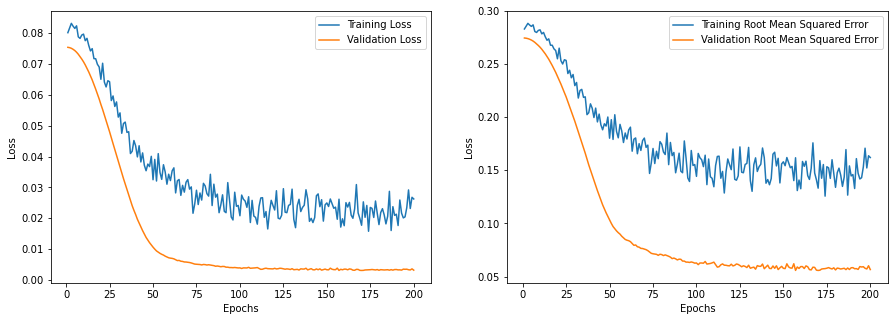

In [187]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

In [200]:
# make predictions
egld_prediction = egld_model.predict(X_test)

# invert predictions

# create empty table with 4 fields
egld_prediction_dataset_like = np.zeros(shape=(len(egld_prediction), 4))
# put the predicted values in the right field
egld_prediction_dataset_like[:,0] = egld_prediction[:,0]
# inverse transform and then select the right field
egld_prediction = X_scaler.inverse_transform(egld_prediction_dataset_like)[:,0]
egld_prediction = egld_prediction.reshape(-1,1)

trainY = y_scaler.inverse_transform(y_train)
testY = y_scaler.inverse_transform(y_test)

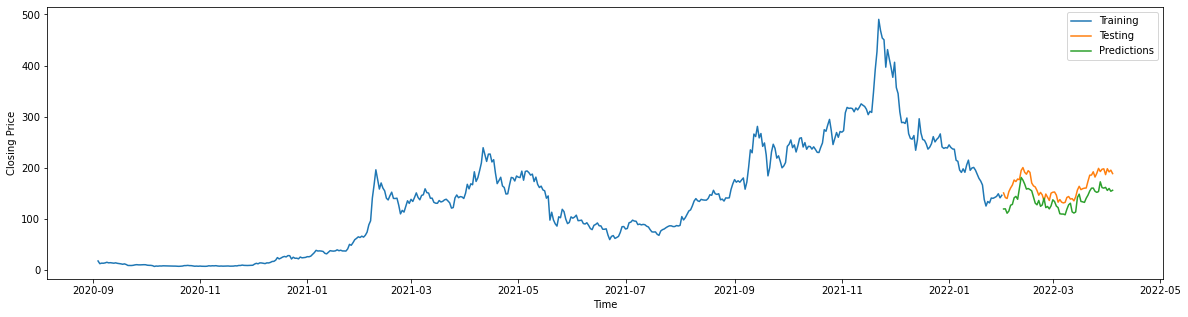

In [205]:
plt.figure(figsize=(20, 5))
plt.plot(df['Date'][df['Date'] < date], trainY, label = 'Training')
plt.plot(df['Date'][df['Date'] >= date], testY, label = 'Testing')
plt.plot(df['Date'][df['Date'] >= date], egld_prediction, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

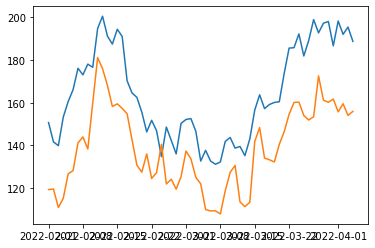

In [206]:
plt.plot(df['Date'][df['Date'] >= date], df['Close'][df['Date'] >= date], label = 'Testing')
plt.plot(df['Date'][df['Date'] >= date], egld_prediction, label = 'Predictions')